# load package：

In [31]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score,  precision_recall_fscore_support
from pySankey.sankey import sankey
from sklearn.metrics import confusion_matrix
import os

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
sc.settings.set_figure_params(dpi=150)

In [26]:
def stratified_split_with_min_train(adata, stratify_col, test_ratio=0.99, random_state=None):
    unique_cell_types = adata.obs[stratify_col].unique()
    
    fixed_train_indices = []
    for cell_type in unique_cell_types:
        cell_type_indices = adata.obs[adata.obs[stratify_col] == cell_type].index
        if len(cell_type_indices) > 1: 
            fixed_train_indices.append(np.random.choice(cell_type_indices, 1, replace=False)[0])
        else:
            fixed_train_indices.append(cell_type_indices[0])
    
    remaining_indices = list(set(adata.obs.index) - set(fixed_train_indices))
    
    train_idx_remaining, test_idx = train_test_split(
        remaining_indices,
        test_size=test_ratio,
        stratify=adata.obs.loc[remaining_indices, stratify_col],
        random_state=random_state
    )
    
    train_idx = list(train_idx_remaining) + fixed_train_indices
    
    return train_idx, test_idx

def load_and_process_data(dataset, data_type, h5ad_path, emb_path):
    if data_type == 'scM':
        models = ['SCARF_RNA', 'SCARF_ATAC']
    elif data_type == 'scA':
        models = ['SCARF_ATAC']
    elif data_type == 'scR':
        models = ['SCARF_RNA']
    else:
        raise ValueError("Unsupported data_type. Choose from 'scM', 'scA', or 'scR'.")

    if data_type in ['scM', 'scR']:
        adata = sc.read_h5ad(f'{h5ad_path}/{dataset}/gex.h5ad')
    elif data_type == 'scA':
        adata = sc.read_h5ad(f'{h5ad_path}/{dataset}/atac.h5ad')
    else:
        raise ValueError("Unsupported data_type. Choose from 'scM', 'scA', or 'scR'.")
    
    for model in models:
        embedding_path = f'{emb_path}/SCARF/Out0/{dataset}/rna_cell_embs.npy' if model == 'SCARF_RNA' else f'{emb_path}/SCARF/Out0/{dataset}/atac_cell_embs.npy'
        cell_name_path = f'{emb_path}/SCARF/Out0/{dataset}/cell_names.npy'

        embedding = np.load(embedding_path)
        cell_name = np.load(cell_name_path, allow_pickle=True)
        
        adata = adata[cell_name].copy()
        adata.obsm[model] = embedding
        
        if model == 'SCARF_RNA':
            SCARF_RNA_embedding = embedding
        elif model == 'SCARF_ATAC':
            SCARF_ATAC_embedding = embedding
            
    if 'SCARF_RNA' in models and 'SCARF_ATAC' in models:
        adata.obsm['SCARF_RNA_ATAC'] = np.hstack([SCARF_RNA_embedding, SCARF_ATAC_embedding])
    
    return adata
    
def train_and_evaluate_embeddings(adata, dataset, stratify_col='cell_type', test_ratio=0.9, random_state=42,
                                   default_embeddings=None, save_dir='./figures'):
    """
    Train and evaluate the specified embeddings using logistic regression.
    
    Parameters:
    adata : AnnData
        The AnnData object containing the dataset and embeddings.
    dataset : str
        Name of the dataset, used for saving results.
    stratify_col : str
        The observation column used for stratified splitting.
    test_ratio : float
        The proportion of the dataset to include in the test split.
    random_state : int
        The seed used by the random number generator.
    default_embeddings : list of str
        List of potential embedding representations to use for training.
    save_dir : str
        Directory to save the figures.

    Returns:
    results_df : DataFrame
        A DataFrame containing the evaluation metrics for each embedding.
    """

    # Stratified split
    train_idx, test_idx = stratified_split_with_min_train(adata, stratify_col=stratify_col,
                                                           test_ratio=test_ratio, random_state=random_state)
    adata_train = adata[train_idx].copy()
    adata_test = adata[test_idx].copy()

    # UMAP visualization setup
    if 'SCARF_RNA' in adata_test.obsm:
        use_rep = 'SCARF_RNA'
    elif 'SCARF_ATAC' in adata_test.obsm:
        use_rep = 'SCARF_ATAC'
    else:
        raise ValueError("Neither 'SCARF_RNA' nor 'SCARF_ATAC' embeddings are available in adata_test.")

    sc.pp.neighbors(adata_test, use_rep=use_rep)    
    sc.tl.umap(adata_test)    
    sc.pl.umap(adata_test, color=stratify_col, return_fig=False)

    # Colors for cell types
    cell_types = adata_test.obs[stratify_col].cat.categories
    colors = adata_test.uns[f'{stratify_col}_colors']
    cell_type_color_dict = dict(zip(cell_types, colors))

    if default_embeddings is None:
        default_embeddings = ['SCARF_RNA', 'SCARF_ATAC', 'SCARF_RNA_ATAC']

    embeddings = [embedding for embedding in default_embeddings if embedding in adata.obsm]

    y_train = adata_train.obs[stratify_col].values
    y_test = adata_test.obs[stratify_col].values

    results = []
    os.makedirs(save_dir, exist_ok=True)

    for embedding in embeddings:
        print(f"Training with {embedding}...")

        X_train = adata_train.obsm[embedding]
        X_test = adata_test.obsm[embedding]

        clf = LogisticRegression(class_weight='balanced', max_iter=1000, C=100, solver='lbfgs', multi_class='multinomial')
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        adata_test.obs[f'Prediction_{embedding}'] = y_pred

        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        results.append({
            'embedding': embedding,
            'accuracy': acc,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })

        cm = confusion_matrix(y_test, y_pred, labels=cell_types)

        cm_normalized = np.round(cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] * 100).astype(int)  

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=True, fmt='d', cmap='Blues', xticklabels=cell_types, yticklabels=cell_types)
        plt.xlabel('Predicted annotation')
        plt.ylabel('Author annotation')
        plt.title(f'Confusion Matrix for {embedding} (Normalized to percentage)')
        plt.savefig(f"{save_dir}/{dataset}_{test_ratio}_confusion_matrix_{embedding}.pdf", bbox_inches="tight", dpi=300)
        plt.close()
        print(f"Confusion matrix for {embedding} saved.")

        plt.figure(figsize=(6, 12))
        sankey(
            adata_test.obs[stratify_col],
            adata_test.obs[f'Prediction_{embedding}'],
            aspect=60,
            colorDict=cell_type_color_dict,
            fontsize=15
        )
        fig = plt.gcf()
        fig.set_facecolor("w")
        fig.savefig(f"{save_dir}/{dataset}_{test_ratio}_sankey_{embedding}.pdf", bbox_inches="tight", dpi=300)
        plt.close()
        print(f"Sankey for {embedding} saved.")

    results_df = pd.DataFrame(results)
    results_df['dataset'] = dataset
    results_df['test_ratio'] = test_ratio
    print(results_df)
    results_df.to_csv(f'./{dataset}_{test_ratio}_save_result.csv', index=False)

    return results_df

# 批量跑结果：

In [27]:
h5ad_path = '../../12_evaluation_data/raw_data/'
emb_path = '../../11_EpiAgent/04_evaluation_final/embedding/'

## scM

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f7318586ca0>
Traceback (most recent call last):
  File "/data/opt/sysoft/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/data/opt/sysoft/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data/opt/sysoft/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/data/opt/sysoft/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' ob

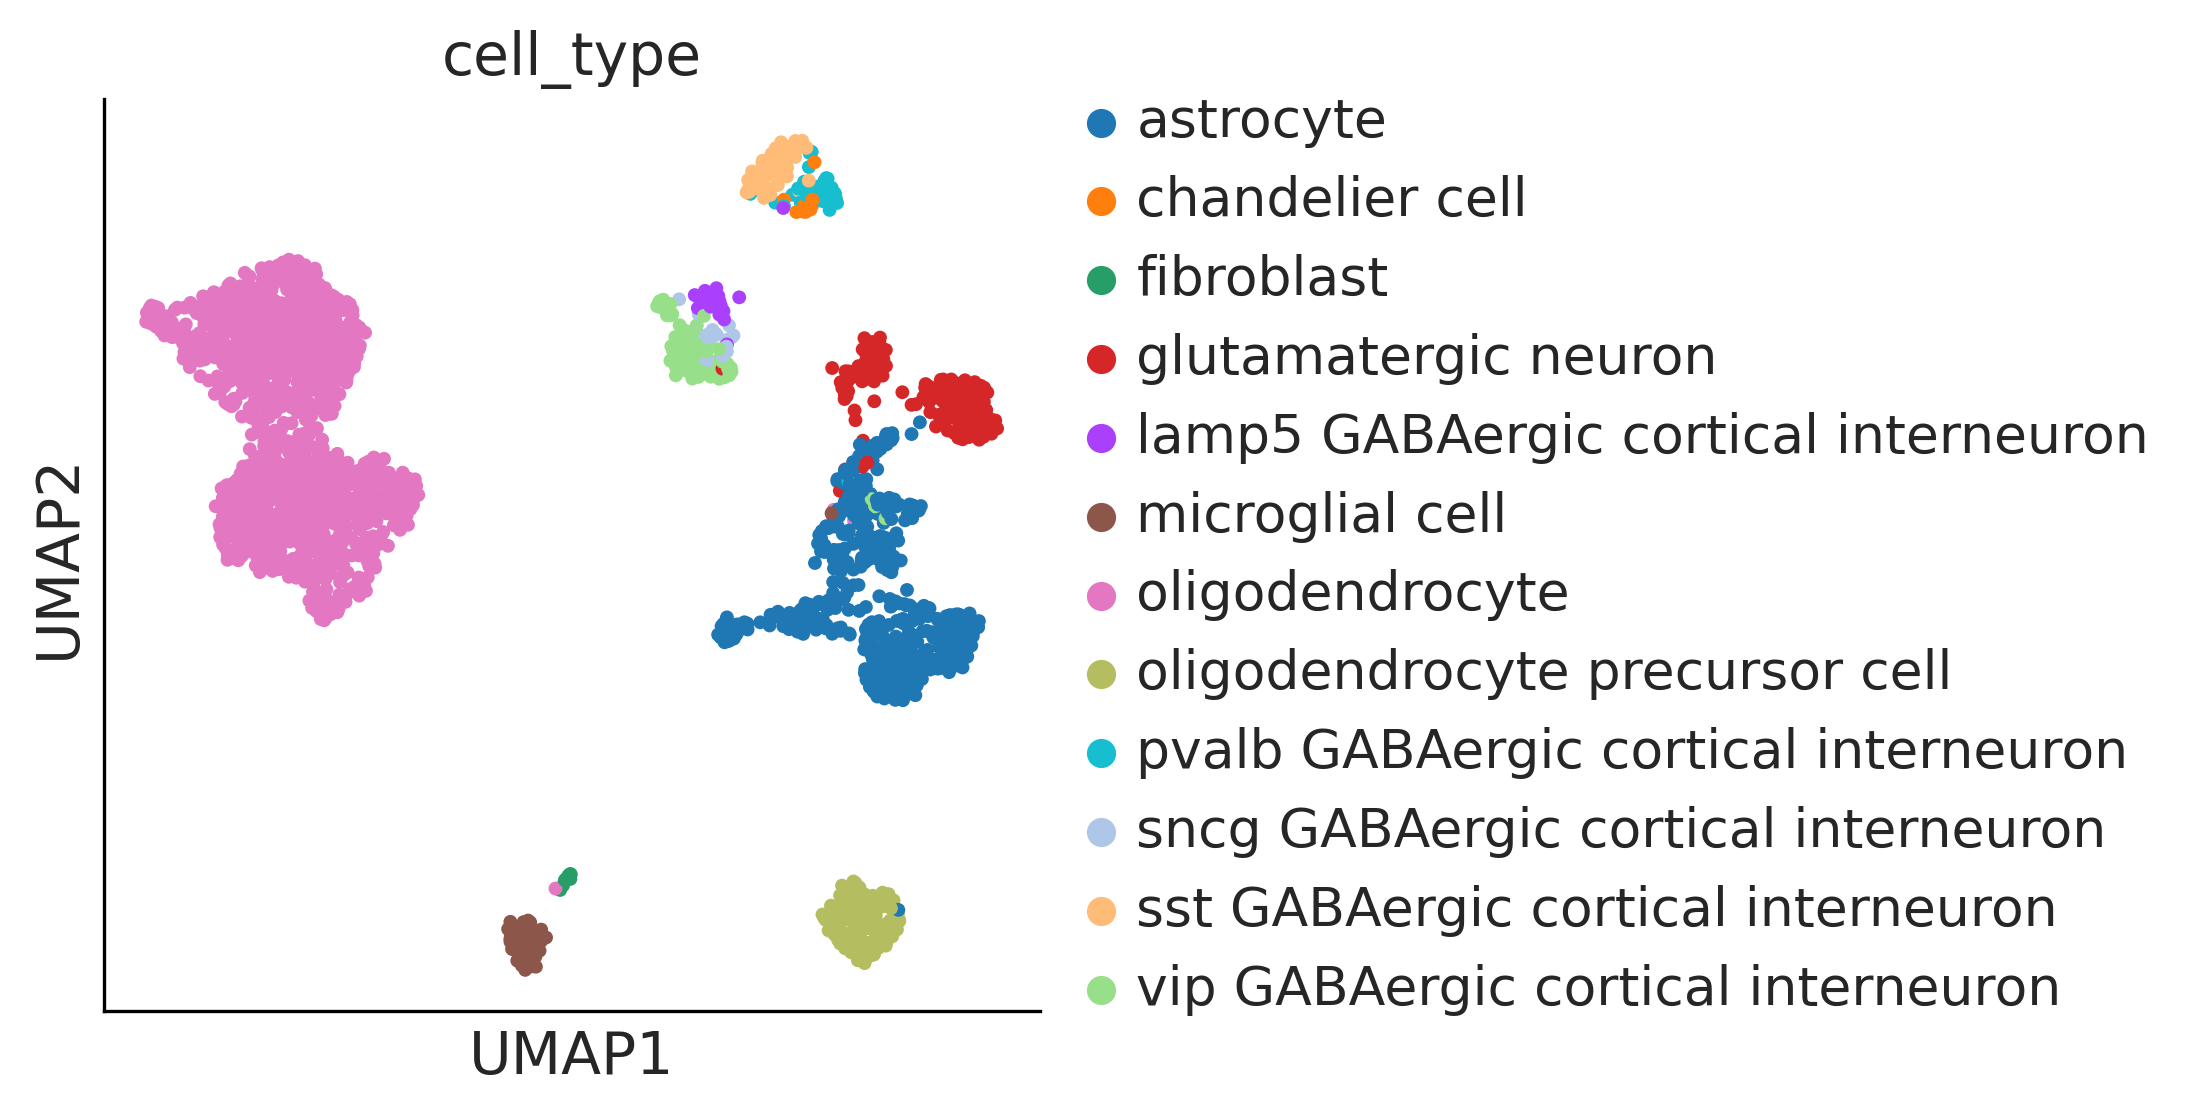

Training with SCARF_RNA...
Confusion matrix for SCARF_RNA saved.
Sankey for SCARF_RNA saved.
Training with SCARF_ATAC...
Confusion matrix for SCARF_ATAC saved.
Sankey for SCARF_ATAC saved.
Training with SCARF_RNA_ATAC...
Confusion matrix for SCARF_RNA_ATAC saved.
Sankey for SCARF_RNA_ATAC saved.
        embedding  accuracy  precision    recall  f1_score            dataset  \
0       SCARF_RNA  0.950808   0.953614  0.950808  0.949350  01_hBrain_10xDemo   
1      SCARF_ATAC  0.928047   0.939877  0.928047  0.929189  01_hBrain_10xDemo   
2  SCARF_RNA_ATAC  0.949706   0.954901  0.949706  0.949465  01_hBrain_10xDemo   

   test_ratio  
0        0.99  
1        0.99  
2        0.99  


<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

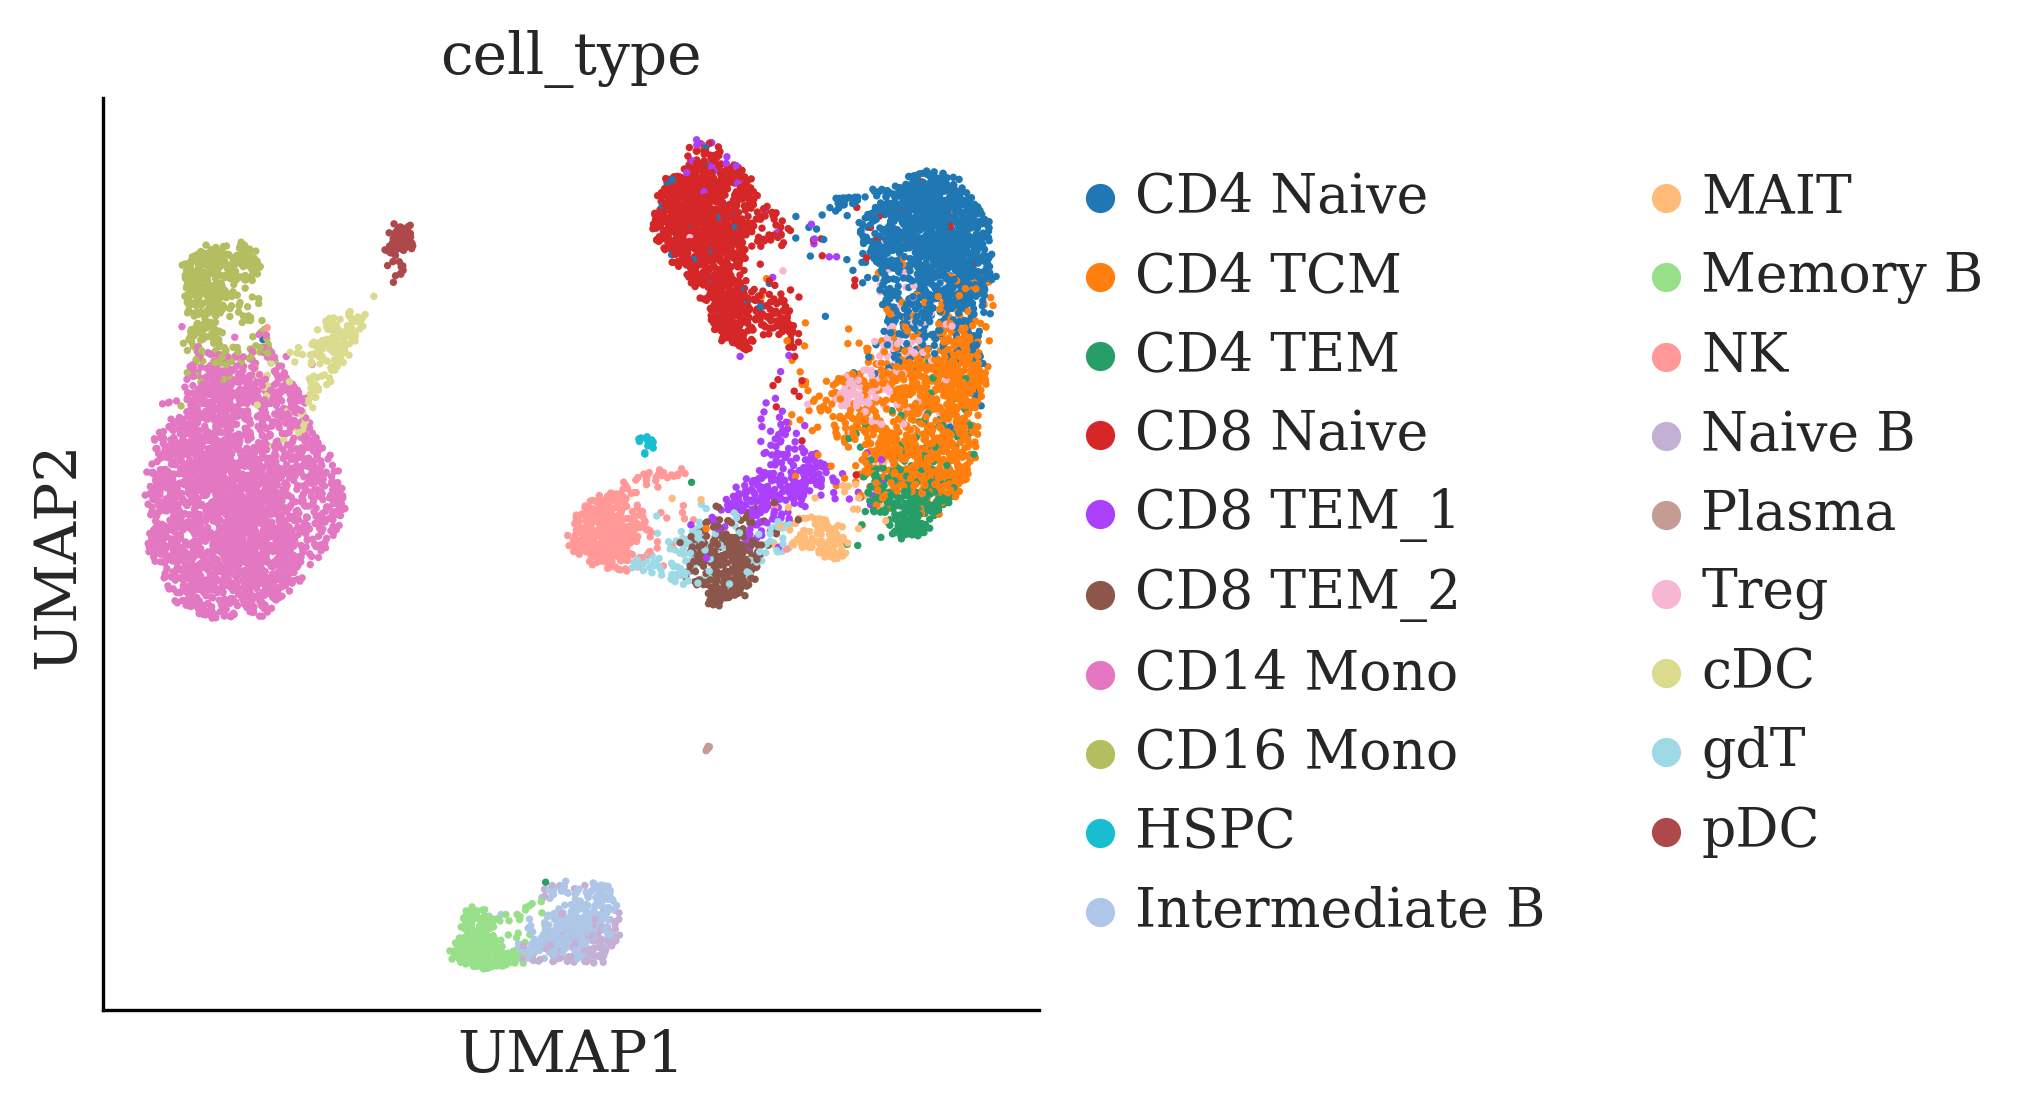

Training with SCARF_RNA...
Confusion matrix for SCARF_RNA saved.
Sankey for SCARF_RNA saved.
Training with SCARF_ATAC...
Confusion matrix for SCARF_ATAC saved.
Sankey for SCARF_ATAC saved.
Training with SCARF_RNA_ATAC...
Confusion matrix for SCARF_RNA_ATAC saved.
Sankey for SCARF_RNA_ATAC saved.
        embedding  accuracy  precision    recall  f1_score  \
0       SCARF_RNA  0.861391   0.879415  0.861391  0.858811   
1      SCARF_ATAC  0.868852   0.896719  0.868852  0.869447   
2  SCARF_RNA_ATAC  0.894493   0.906605  0.894493  0.893683   

                       dataset  test_ratio  
0  09_hPBMC_10k_scGLUE_10xDemo        0.99  
1  09_hPBMC_10k_scGLUE_10xDemo        0.99  
2  09_hPBMC_10k_scGLUE_10xDemo        0.99  


/data/home/jkchen/yyzhao/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/home/jkchen/yyzhao/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/home/jkchen/yyzhao/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/home/jkchen/yyzhao/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/home/jkchen/yyzhao/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarn

<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

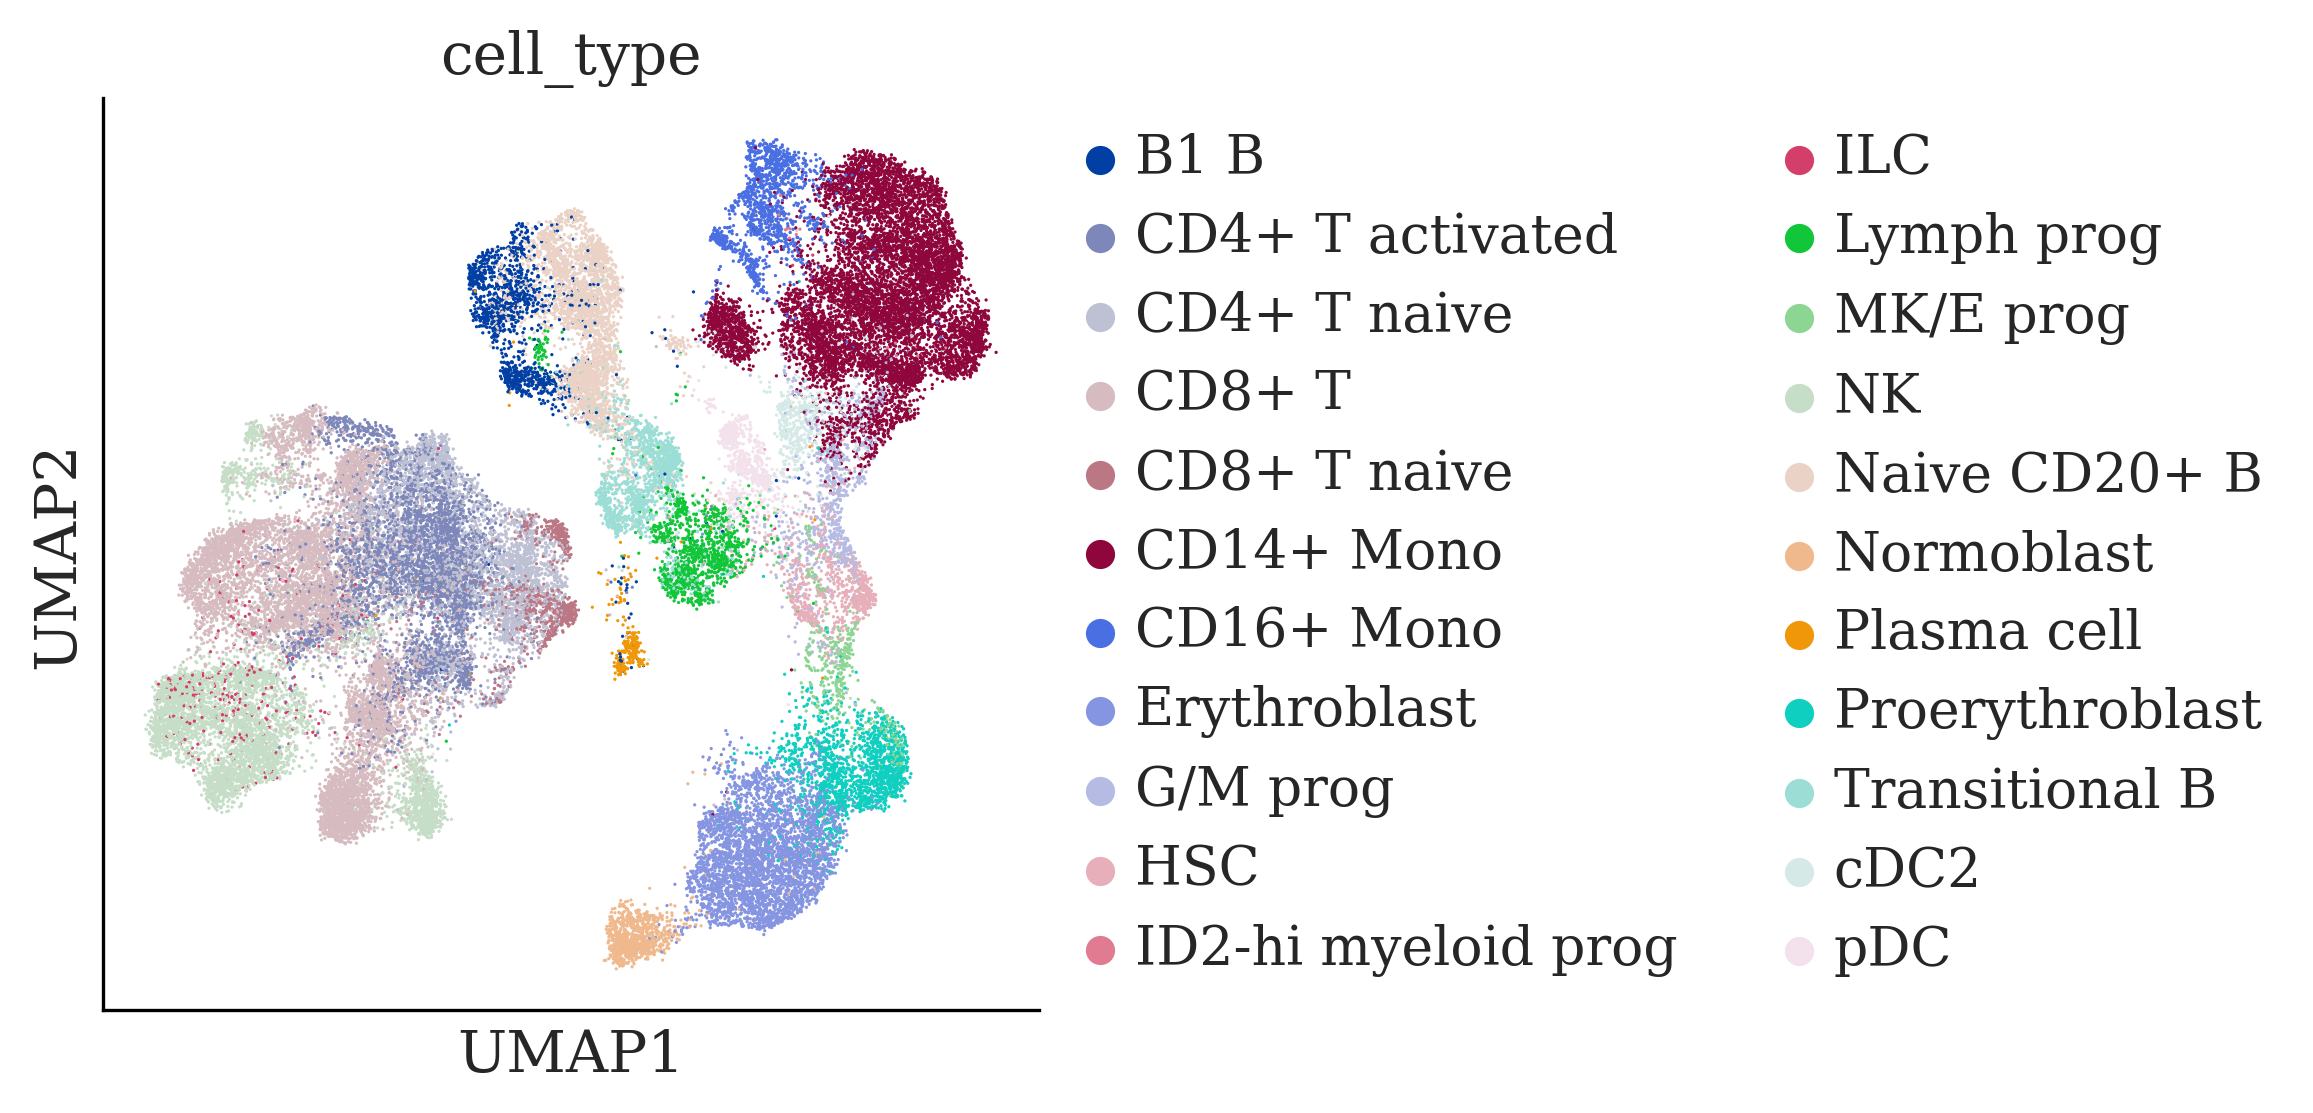

Training with SCARF_RNA...
Confusion matrix for SCARF_RNA saved.
Sankey for SCARF_RNA saved.
Training with SCARF_ATAC...
Confusion matrix for SCARF_ATAC saved.
Sankey for SCARF_ATAC saved.
Training with SCARF_RNA_ATAC...
Confusion matrix for SCARF_RNA_ATAC saved.
Sankey for SCARF_RNA_ATAC saved.
        embedding  accuracy  precision    recall  f1_score       dataset  \
0       SCARF_RNA  0.799557   0.830386  0.799557  0.810538  10_hBMMC_10x   
1      SCARF_ATAC  0.787499   0.811994  0.787499  0.794508  10_hBMMC_10x   
2  SCARF_RNA_ATAC  0.829385   0.841368  0.829385  0.833133  10_hBMMC_10x   

   test_ratio  
0        0.99  
1        0.99  
2        0.99  


<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

<Figure size 900x1800 with 0 Axes>

In [28]:
data_type = 'scM'
datasets = ['01_hBrain_10xDemo', '09_hPBMC_10k_scGLUE_10xDemo', '10_hBMMC_10x']

total_results_df = pd.DataFrame()

for dataset in datasets:
    adata = load_and_process_data(dataset, data_type, h5ad_path, emb_path)
    results_df = train_and_evaluate_embeddings(adata, dataset,test_ratio=test_ratio)
    total_results_df = pd.concat([total_results_df, results_df], ignore_index=True)

In [29]:
total_results_df

,embedding,accuracy,precision,recall,f1_score,dataset,test_ratio
0,SCARF_RNA,0.950808,0.953614,0.950808,0.949350,01_hBrain_10xDemo,0.99
1,SCARF_ATAC,0.928047,0.939877,0.928047,0.929189,01_hBrain_10xDemo,0.99
2,SCARF_RNA_ATAC,0.949706,0.954901,0.949706,0.949465,01_hBrain_10xDemo,0.99
3,SCARF_RNA,0.861391,0.879415,0.861391,0.858811,09_hPBMC_10k_scGLUE_10xDemo,0.99
4,SCARF_ATAC,0.868852,0.896719,0.868852,0.869447,09_hPBMC_10k_scGLUE_10xDemo,0.99
5,SCARF_RNA_ATAC,0.894493,0.906605,0.894493,0.893683,09_hPBMC_10k_scGLUE_10xDemo,0.99
6,SCARF_RNA,0.799557,0.830386,0.799557,0.810538,10_hBMMC_10x,0.99
7,SCARF_ATAC,0.787499,0.811994,0.787499,0.794508,10_hBMMC_10x,0.99
8,SCARF_RNA_ATAC,0.829385,0.841368,0.829385,0.833133,10_hBMMC_10x,0.99


In [30]:
total_results_df.to_csv("scM.csv")